## main

the minimumrequire 137.9
Loaded trained policy network for inference!

=== Running simulation 1/400 ===
Set parameter LogToConsole to value 0


/tmp/ipykernel_714474/2222584444.py:1447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adss_agent.policy_net.load_state_dict(torch.load("ppo_policy_net.pth"))



=== Running simulation 2/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 3/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 4/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 5/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 6/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 7/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 8/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 9/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 10/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 11/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 12/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 13/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 14/400 ===
Set parameter LogToConsole to value 0

=== Running simulation 15/400 ===
Set parameter LogToConso

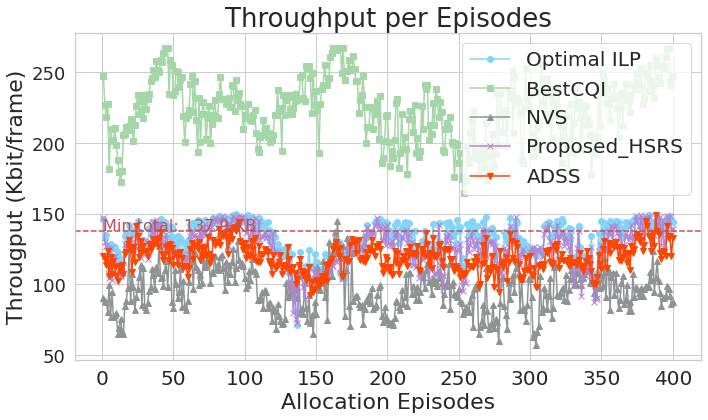

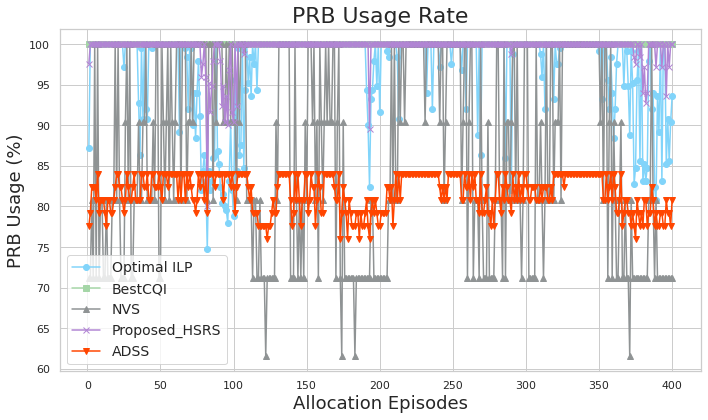

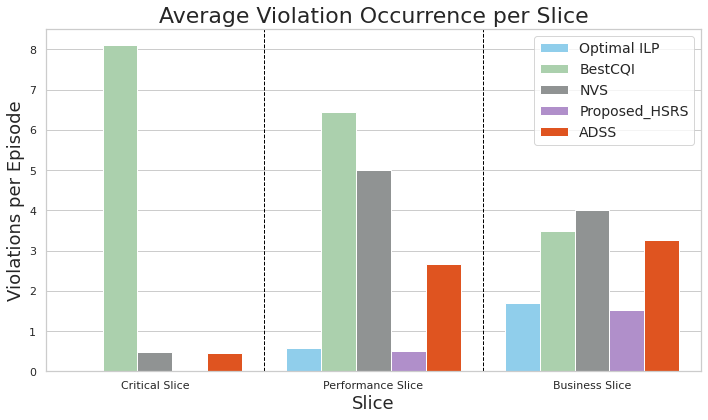

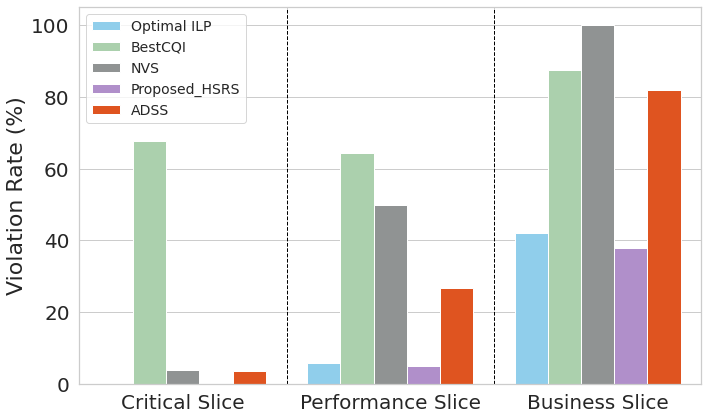

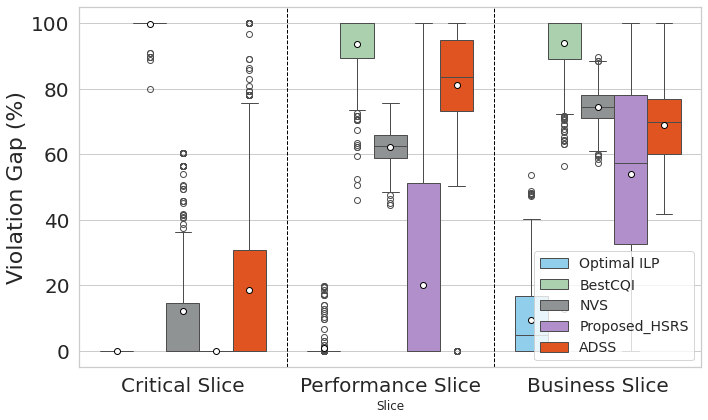

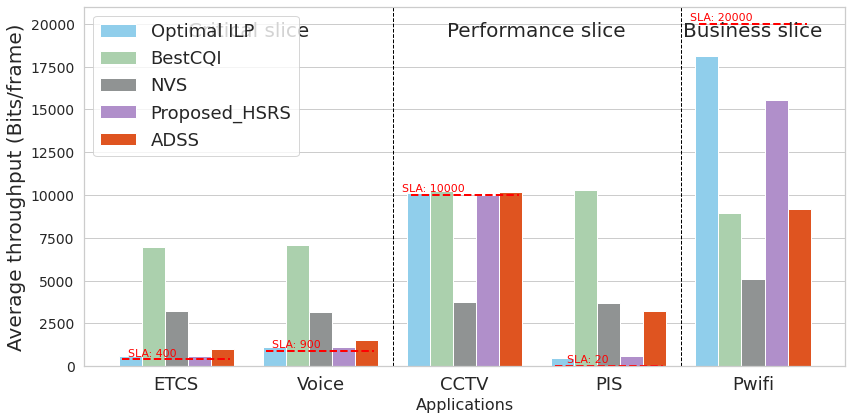

In [5]:
import random
import numpy as np
import pandas as pd
import time 
from gurobipy import Model, GRB, quicksum

from stable_baselines3.common.noise import NormalActionNoise
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import os
from functools import lru_cache
from collections import defaultdict
         

K = 25  #number of PRB
T = 10  #number of Slot
num_simulations = 400

    
# Apps SLA dictionaries in bits
SLA_critic = {1: 400, 2:900}   
SLA_perf   = {3: 10000, 4: 20}  
SLA_busi   = {5: 20000}        


# Application categories identifier
Ac = [1, 2]  # critical 1: ETCS  2: Voice 
Ap = [3, 4]  # performance  3: CCTV , 4: PID
Ab = [5]     # Business 5: Pwifi

U_c = 6 # number of critical UE
U_p = 5 # number of performance UE
U_b = 4 # number of business UE
hidden_size=128
n_steps=25
agent_gamma = 0.97
lam=0.25
clip_range=0.96
lr=0.02
batch_size=64
n_epochs=8
alpha=0.8
lambda_weight=0.5
weights = {1:60, 2:8, 3:2}
total_timesteps=2000
partial_train_steps= 2000
train_episode= 10

# Application labels
app_labels = ['ETCS', 'Voice', 'CCTV', 'PIS', 'Pwifi']
sla_values = [
    SLA_critic.get(1, 0),
    SLA_critic.get(2, 0),
    SLA_perf.get(3, 0),
    SLA_perf.get(4, 0),
    SLA_busi.get(5, 0)
]

#Data Rate parameters

J = 1  # Number of component carriers
v_Llayers = 1  # Maximum number of MIMO layers

OH = 0.14  # Overhead (e.g., FR1 DL)
f = 1  # Scaling factor
mu = 0  # Numerology (0 for 15 kHz SCS)

# CQI to Modulation Order (Q_m)
CQI_TO_MCS = {
    1: 2, 2: 2, 3: 2, 4: 4, 5: 4,
    6: 4, 7: 4, 8: 6, 9: 6, 10: 6,
    11: 6, 12: 6, 13: 8, 14: 8, 15: 8
}

# CQI to Coding Rate (R_max)
CQI_TO_Rmax = {
    1: 0.07617188,  # QPSK
    2: 0.18847656,  # QPSK
    3: 0.43847656,  # QPSK
    4: 0.36914063,  # QPSK
    5: 0.47851563,  # QPSK
    6: 0.6015625,   # QPSK
    7: 0.45507813,  # 16-QAM
    8: 0.55371094,  # 16-QAM
    9: 0.65039063,  # 16-QAM
    10: 0.75390625, # 64-QAM
    11: 0.85253906, # 64-QAM
    12: 0.69433594, # 64-QAM
    13: 0.77832031, # 64-QAM
    14: 0.86425781, # 64-QAM
    15: 0.92578125, # 64-QAM
}

# OFDM symbol duration (T_s) based on numerology
T_s = 10**-3 / (14 * 2**mu)  

def calculate_minmum_required_datarate():
    # Sum required bits for critical, performance and business  apps 
    crit_req = U_c * (SLA_critic[1] + SLA_critic[2])
    
    perf_req = U_p * (SLA_perf[3] + SLA_perf[4])
    
    busi_req = U_b * SLA_busi[5]
    
    total_required_bits = crit_req + perf_req + busi_req
    total_required_bits = total_required_bits/1000 
    return total_required_bits
min_required_datarate_KB = calculate_minmum_required_datarate()
print(f"the minimumrequire {min_required_datarate_KB}")


# ------------------------------------------------------------
# generate_gamma(): using real sub-band-CQI measurements
# ------------------------------------------------------------

DATA_DIR = "subband_cqi"            # folder that holds TOBA gateway subband CQI : UE0.csv … UE<n>.csv


@lru_cache(maxsize=None)
def _load_ue_dataframe(ue_idx: int) -> pd.DataFrame:
    """Read (and cache) the CSV of one UE."""
    path = os.path.join(DATA_DIR, f"Subband_UE{ue_idx}.csv")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Missing CQI file: {path}")
    return pd.read_csv(path)

def _pick_row(df: pd.DataFrame, time_idx: Optional[int] = None) -> pd.Series:
    """Return one row of CQI values (RGB0…RGB6)."""
    if time_idx is None:                       # if no index specified choose a random instant
        return df.sample(n=1).iloc[0]
    else:                                      # else deterministic index specified
        return df.iloc[time_idx % len(df)]

def _rgb_for_prb(k_: int) -> int:
    """Map PRB index → RGB index (0-6)."""
    return k_ // 4 if k_ < 24 else 6

def generate_gamma(time_idx: Optional[int] = None):
    """
    Build the γ-dictionary using real CQI traces.
    these achievable data rate base on subband CQI
    Parameters
    ----------
    time_idx : int or None
        • None  → use a random row from each UE file (default)  
        • int   → deterministic: row `time_idx` 
    """
    gamma = {}

    def add_entries(local_i: int, global_i: int, slice_id: int, apps: list[int]):
        # --- pick one CQI row for this UE --------------------
        row = _pick_row(_load_ue_dataframe(global_i), time_idx)
        rgb_cqi = [int(row[f"RGB{g}"]) for g in range(7)]

        for a in apps:                        # same CQI for every app of that UE (=TOBA Garteway)
            for k_ in range(K):               # PRB ➜ RGB mapping
                cqi = rgb_cqi[_rgb_for_prb(k_)]
                R_max = CQI_TO_Rmax.get(cqi, 0)
                Q_m   = CQI_TO_MCS .get(cqi, 0)
                thr = (1e-3 * J * v_Llayers * Q_m * f * R_max * (12 / T_s) * (1 - OH))
                gamma[(global_i, a, slice_id, k_)] = thr   # **global_i here**

    # ── enter appplications into gamma based on specifie Number of user in Ac, Ab and Ac (Critic. Perf.Busi)
    for i in range(U_c):
        add_entries(i, i, 1, Ac)
    
    for i in range(U_p):
        add_entries(i, U_c + i, 2, Ap)

    for i in range(U_b):
        add_entries(i, U_c + U_p + i, 3, Ab)

    return gamma

#build list of applications
def build_appkey_list():
    appkey_list = []

    # Critical slice (UE 0-5)
    for i in range(U_c):
        for a in Ac:
            appkey_list.append((i, a, 1))

    # Performance slice (UE 6-10)
    for i in range(U_p):
        g = U_c + i
        for a in Ap:
            appkey_list.append((g, a, 2))

    # Business slice (UE 11-14)
    for i in range(U_b):
        g = U_c + U_p + i
        for a in Ab:
            appkey_list.append((g, a, 3))

    return appkey_list

APPKEY_LIST = build_appkey_list()
N_APPKEYS = len(APPKEY_LIST)

def get_sla(app):
    if app in SLA_critic:
        return SLA_critic[app]
    if app in SLA_perf:
        return SLA_perf[app]
    if app in SLA_busi:
        return SLA_busi[app]
    return 0

def get_slice_for_app(app_id):
    if app_id in Ac:
        return 1
    elif app_id in Ap:
        return 2
    else:
        return 3

def get_num_users_for_slice(slice_id):
    if slice_id == 1:
        return U_c
    elif slice_id == 2:
        return U_p
    elif slice_id == 3:
        return U_b

def run_allocation_solver(gamma, wc=0.01, wp=0.6, wb=1):
    """
    Optimal ILP (Gurobi) allocation 
    """

    # Sort TOBA gatexyas (UE)  ids per slices
    crit_users = sorted({i for (i, a, s, _) in gamma if s == 1})  
    perf_users = sorted({i for (i, a, s, _) in gamma if s == 2})  
    busi_users = sorted({i for (i, a, s, _) in gamma if s == 3})  

    U_c, U_p, U_b = len(crit_users), len(perf_users), len(busi_users)

    # ------------------------------------------------------------
    # 1)  Model & variables 
    # ------------------------------------------------------------
    model = Model("Optimal_ILP")
    model.Params.LogToConsole = 0
    model.setParam("NodefileStart", 0.010)
    model.setParam("NodefileDir", "/tmp")
    model.setParam("Threads", 16)
    model.setParam("MIPFocus", 1)
    model.setParam("ConcurrentMIP", 4)
    model.setParam("TimeLimit", 10) 

    x = model.addVars(U_c, len(Ac), K, T, vtype=GRB.BINARY, name="x")
    y = model.addVars(U_p, len(Ap), K, T, vtype=GRB.BINARY, name="y")
    z = model.addVars(U_b, len(Ab), K, T, vtype=GRB.BINARY, name="z")

    SlackCrit = model.addVars(U_c, len(Ac), vtype=GRB.CONTINUOUS, lb=0)
    SlackPerf = model.addVars(U_p, len(Ap), vtype=GRB.CONTINUOUS, lb=0)
    SlackBus  = model.addVars(U_b, len(Ab), vtype=GRB.CONTINUOUS, lb=0)

    # 2)  PRB-capacity constraints 

    for t_ in range(T):
        for k_ in range(K):
            model.addConstr(quicksum(x[i, a, k_, t_] for i in range(U_c) for a in range(len(Ac))) <= 1)
            model.addConstr(quicksum(y[i, a, k_, t_] for i in range(U_p) for a in range(len(Ap))) <= 1)
            model.addConstr(quicksum(z[i, a, k_, t_] for i in range(U_b) for a in range(len(Ab))) <= 1)

            model.addConstr(
                quicksum(x[i, a, k_, t_] for i in range(U_c) for a in range(len(Ac))) +
                quicksum(y[i, a, k_, t_] for i in range(U_p) for a in range(len(Ap))) +
                quicksum(z[i, a, k_, t_] for i in range(U_b) for a in range(len(Ab))) <= 1
            )

    # 3)  SLA constraints for each Slice

    for i_loc in range(U_c):
        i_glob = crit_users[i_loc]
        for a_idx, a in enumerate(Ac):
            model.addConstr(
                quicksum(
                    x[i_loc, a_idx, k_, t_] * gamma.get((i_glob, a, 1, k_), 0)
                    for k_ in range(K) for t_ in range(T)
                ) >= SLA_critic[a]
            )

    for i_loc in range(U_p):
        i_glob = perf_users[i_loc]
        for a_idx, a in enumerate(Ap):
            model.addConstr(
                quicksum(
                    y[i_loc, a_idx, k_, t_] * gamma.get((i_glob, a, 2, k_), 0)
                    for k_ in range(K) for t_ in range(T)
                )+ SlackPerf[i_loc, a_idx] >= SLA_perf[a]
            )

    for i_loc in range(U_b):
        i_glob = busi_users[i_loc]
        for a_idx, a in enumerate(Ab):
            model.addConstr(
                quicksum(
                    z[i_loc, a_idx, k_, t_] * gamma.get((i_glob, a, 3, k_), 0)
                    for k_ in range(K) for t_ in range(T)
                ) + SlackBus[i_loc, a_idx] >= SLA_busi[a]
            )

    # 4)  Objective 

    alpha_c, alpha_p, alpha_b = 2000, 2000, 1000
    model.setObjective(
        wp * quicksum(y[i, a, k_, t] for i in range(U_p) for a in range(len(Ap)) for k_ in range(K) for t in range(T))
      + wb * quicksum(z[i, a, k_, t] for i in range(U_b) for a in range(len(Ab)) for k_ in range(K) for t in range(T))
      + wc * quicksum(x[i, a, k_, t] for i in range(U_c) for a in range(len(Ac)) for k_ in range(K) for t in range(T))
      + alpha_b * quicksum(SlackBus[i, a] / SLA_busi[Ab[a]] for i in range(U_b) for a in range(len(Ab)))
      + alpha_p * quicksum(SlackPerf[i, a] / SLA_perf[Ap[a]] for i in range(U_p) for a in range(len(Ap))),
      GRB.MINIMIZE
    )

 
    # 5)  Solve

    try:
        model.optimize()
    except Exception as e:
        print(f"Gurobi optimization failed: {e}")
        return (None,)*7

    if model.SolCount == 0:          # no feasible solution found at all
        print("No incumbent solution.")
        return (None,)*7

    # ------------------------------------------------------------
    # 6)  Extract the solution 
    # ------------------------------------------------------------
    prb_assignments, total_throughput = [], 0.0

    for t_ in range(T):
        for k_ in range(K):

            # --- critical slice
            for i_loc in range(U_c):
                i_glob = crit_users[i_loc]
                for a_idx, a in enumerate(Ac):
                    if x[i_loc, a_idx, k_, t_].X > 0.5:
                        thr = gamma.get((i_glob, a, 1, k_), 0)
                        prb_assignments.append((t_, k_, i_glob, a, 1, thr))
                        total_throughput += thr

            # --- performance slice
            for i_loc in range(U_p):
                i_glob = perf_users[i_loc]
                for a_idx, a in enumerate(Ap):
                    if y[i_loc, a_idx, k_, t_].X > 0.5:
                        thr = gamma.get((i_glob, a, 2, k_), 0)
                        prb_assignments.append((t_, k_, i_glob, a, 2, thr))
                        total_throughput += thr

            # --- business slice
            for i_loc in range(U_b):
                i_glob = busi_users[i_loc]
                for a_idx, a in enumerate(Ab):
                    if z[i_loc, a_idx, k_, t_].X > 0.5:
                        thr = gamma.get((i_glob, a, 3, k_), 0)
                        prb_assignments.append((t_, k_, i_glob, a, 3, thr))
                        total_throughput += thr

    # ------------------------------------------------------------
    # 7)  Metrics & DataFrames 
    # ------------------------------------------------------------
    allocation_df = pd.DataFrame(prb_assignments,
                                 columns=['Slot', 'PRB', 'User', 'App', 'Slice', 'Throughput'])
    allocation_df['App_Key'] = allocation_df.apply(
        lambda r: (r['User'], r['App'], r['Slice']), axis=1)

    app_throughput_df = (allocation_df.groupby('App_Key')['Throughput']
                         .sum().reset_index())
    app_throughput_df[['User', 'App', 'Slice']] = pd.DataFrame(
        app_throughput_df['App_Key'].tolist(), index=app_throughput_df.index)
    app_throughput_df.drop(columns=['App_Key'], inplace=True)

    app_episode_thr = (app_throughput_df.groupby('App')['Throughput']
                       .mean().reset_index()
                       .rename(columns={'Throughput': 'Average_Throughput'}))


    violation_counts_per_slice = {1: 0, 2: 0, 3: 0}
    violation_gap_per_slice    = {1: 0, 2: 0, 3: 0}
    for _, row in app_throughput_df.iterrows():
        i, a, s, thr = row['User'], row['App'], row['Slice'], row['Throughput']
        sla = SLA_critic.get(a, 0) if s == 1 else SLA_perf.get(a, 0) if s == 2 else SLA_busi.get(a, 0)
        if thr < sla:
            violation_counts_per_slice[s] += 1
            violation_gap_per_slice[s]   += abs(sla - thr)

    total_violations = sum(violation_counts_per_slice.values())
    violation_gap_per_slice[1] /= ((SLA_critic[1]+SLA_critic[2]) * U_c)
    violation_gap_per_slice[2] /= ((SLA_perf[3]+SLA_perf[4])     * U_p)
    violation_gap_per_slice[3] /= (SLA_busi[5]                   * U_b)

    return (allocation_df, total_throughput, app_throughput_df,
            app_episode_thr, violation_counts_per_slice,
            total_violations, violation_gap_per_slice)


def run_bestcqi_allocation(gamma):
    """
    Assign each PRB in each time slot to (i, a, s) that has the highest achievable Datarate in gamma
  
    """
    prb_assignments = []

    for t in range(T):
        for k_ in range(K):
            best_thr = -float('inf')
            best_keys = []  # will hold all (i,a,s) that achieve best_thr

            #  Scan through all candidates for this PRB k_
            for (i, a, s, prb) in gamma:
                if prb == k_:
                    thr_val = gamma[(i, a, s, prb)]
                    if thr_val > best_thr:
                        best_thr = thr_val
                        best_keys = [(i, a, s)]
                    elif thr_val == best_thr:
                        best_keys.append((i, a, s))

            #  If we found at least one, pick one  
            if best_keys:
                i_sel, a_sel, s_sel = random.choice(best_keys)
                prb_assignments.append((t, k_, i_sel, a_sel, s_sel, best_thr))

    allocation_df = pd.DataFrame(prb_assignments, 
                                 columns=['Slot', 'PRB', 'User', 'App', 'Slice', 'Throughput'])
    #allocation_df.to_csv("bestcqi_allocation_df.csv", index=False)
    allocation_df['App_Key'] = allocation_df.apply(
        lambda row: (row['User'], row['App'], row['Slice']), axis=1
    )
    
    app_throughput_df = (
        allocation_df.groupby('App_Key')['Throughput'].sum().reset_index()
    )

    app_throughput_df[['User', 'App', 'Slice']] = pd.DataFrame(
        app_throughput_df['App_Key'].tolist(), index=app_throughput_df.index
    )
    app_throughput_df.drop(columns=['App_Key'], inplace=True)
    #app_throughput_df.to_csv("bestcqi_allocation_df.csv", index=False)
    
    # ===  Create a DataFrame of all ID combos from APPKEY_LIST ===
    all_combos_df = pd.DataFrame(APPKEY_LIST, columns=['User','App','Slice'])

    # ===  Merge with app_throughput_df, filling missing ID combos as Throughput=0 ===
    merged_df = all_combos_df.merge(
        app_throughput_df,
        on=['User','App','Slice'],
        how='left'
    )
    merged_df['Throughput'] = merged_df['Throughput'].fillna(0.0)

    # === compute the average throughput per App ===
    app_episode_thr = (
        merged_df
        .groupby('App')['Throughput']
        .mean()
        .reset_index()
        .rename(columns={'Throughput': 'Average_Throughput'})
    )
    merged_df.to_csv("CQI_episode_app.csv", index=True)
    violation_counts_per_slice = {1: 0, 2: 0, 3: 0}
    violation_gap_per_slice = {1: 0, 2: 0, 3: 0}

    for (i_, a_, s_) in APPKEY_LIST:
        # Grab how much throughput was allocated to this (user, app, slice)
        row_match = app_throughput_df[
            (app_throughput_df['User'] == i_) &
            (app_throughput_df['App'] == a_) &
            (app_throughput_df['Slice'] == s_)
        ]
        sla_needed = get_sla(a_)
        if len(row_match) > 0:
            allocated_thr = row_match.iloc[0]['Throughput']
            ratio = allocated_thr / sla_needed
            if ratio < 1 :
                #gap_ratio = 1-ratio 
                violation_counts_per_slice[s_] += 1
                violation_gap_per_slice[s_] += (1.0 - ratio)
            

        else:
            allocated_thr = 0.0
            
            violation_counts_per_slice[s_] += 1
            violation_gap_per_slice[s_] += 1.0


  
    for s_ in [1, 2, 3]:
        if violation_counts_per_slice[s_] > 0:
            violation_gap_per_slice[s_] /= violation_counts_per_slice[s_]
        else:
            violation_gap_per_slice[s_] = 0.0

    total_violations = sum(violation_counts_per_slice.values())
    total_throughput = allocation_df['Throughput'].sum() 

    return (allocation_df, total_throughput, app_throughput_df,
            app_episode_thr, violation_counts_per_slice, total_violations, violation_gap_per_slice,)

def run_myheuristic_allocation(gamma):
    """
    Two-phase cascaded scheduler:
      1) Phase Critique : minimal-slack greedy
      2) Phase Performance & Business : weighted Best-CQI
    """
    w_perf= 0.7
    w_busi= 0.3
    # Initialise slack bits for every app
    slack = {key: get_sla(key[1]) for key in APPKEY_LIST}
    prb_assignments = []

    # Phase 1: Critical slice greedy slack reduction
    for t in range(T):
        for k in range(K):
            best_delta = 0.0
            best_choice = None
            # scan critical apps
            for (i, a, s, prb), g in gamma.items():
                if prb != k or s != 1:
                    continue
                need = slack[(i, a, s)]
                if need <= 0:
                    continue
                delta = min(need, g)
                if delta > best_delta:
                    best_delta = delta
                    best_choice = (i, a, s, g)
            if best_choice:
                i, a, s, g = best_choice
                slack[(i, a, s)] -= best_delta
                prb_assignments.append((t, k, i, a, s, g))

          # Phase 2: Weighted Best-CQI for Performance & Business
            weights = {2: w_perf, 3: w_busi}

            # skip PRBs already allocated in Phase 1
            if any(t == rec[0] and k == rec[1] for rec in prb_assignments):
                continue
            best_score = 0.0
            best_choice = None
            for (i, a, s, prb), g in gamma.items():
                if prb != k or s not in (2, 3):
                    continue
                need = slack[(i, a, s)]
                if need <= 0:
                    continue
                score = g * weights[s]
                if score > best_score:
                    best_score = score
                    best_choice = (i, a, s, g)
            if best_choice:
                i, a, s, g = best_choice
                delta = min(slack[(i, a, s)], g)
                slack[(i, a, s)] -= delta
                prb_assignments.append((t, k, i, a, s, g))

    # Build allocation DataFrame
    allocation_df = pd.DataFrame(
        prb_assignments,
        columns=['Slot', 'PRB', 'User', 'App', 'Slice', 'Throughput']
    )
    allocation_df['App_Key'] = allocation_df.apply(
        lambda r: (r['User'], r['App'], r['Slice']), axis=1
    )

    # Per-app throughput
    app_throughput_df = (
        allocation_df.groupby('App_Key')['Throughput']
                     .sum().reset_index()
    )
    app_throughput_df[['User', 'App', 'Slice']] = pd.DataFrame(
        app_throughput_df['App_Key'].tolist(), index=app_throughput_df.index
    )
    app_throughput_df.drop(columns=['App_Key'], inplace=True)

    # Include zero rows for apps with no allocation
    all_combos = pd.DataFrame(APPKEY_LIST, columns=['User','App','Slice'])
    merged = all_combos.merge(
        app_throughput_df, on=['User','App','Slice'], how='left'
    ).fillna(0.0)

    # Average throughput per episode
    app_episode_thr = (
        merged.groupby('App')['Throughput']
              .mean().reset_index()
              .rename(columns={'Throughput':'Average_Throughput'})
    )

    # Violation counts and gap ratios
    violation_counts_per_slice = {1:0, 2:0, 3:0}
    violation_gap_per_slice = {1:0.0,2:0.0,3:0.0}
    for (i, a, s) in APPKEY_LIST:
        sla = get_sla(a)
        allocated = merged.loc[
            (merged.User==i)&(merged.App==a)&(merged.Slice==s),'Throughput'
        ].iloc[0]
        ratio = allocated / sla if sla>0 else 1.0
        if ratio < 1:
            violation_counts_per_slice[s] += 1
            violation_gap_per_slice[s]   += (1 - ratio)
    for s in violation_gap_per_slice:
        if violation_counts_per_slice[s] > 0:
            violation_gap_per_slice[s] /= violation_counts_per_slice[s]

    total_throughput = allocation_df['Throughput'].sum()
    total_violations = sum(violation_counts_per_slice.values())

    return (
        allocation_df,
        total_throughput,
        app_throughput_df,
        app_episode_thr,
        violation_counts_per_slice,
        total_violations,
        violation_gap_per_slice
    )



def run_nvs_allocation(gamma):
    """
    NVS- static reservation and dynamic reuse of unused slots.
    
    gamma: dict mapping (i, app, slice, prb) -> achievable throughput
    APPKEY_LIST: list of all (user, app, slice) combos
    get_sla: function mapping app -> SLA throughput requirement
    K: total number of PRBs per slot
    """
    prb_assignments = []
    # 1) fixed reservation per slice as SLA (50%,30%,20%)
    slot_reservation = {1: 5, 2: 3, 3: 2}
    current_slot = 0

    # track cumulative allocated throughput per (i, app, slice)
    alloc_thr = defaultdict(float)
    
    # extract per-slice list of (user, app)
    slice_apps = {
        s: sorted({(i, a) for (i, a, s_val, k) in gamma if s_val == s})
        for s in slot_reservation
    }
    
    leftover_slots = []

    # First pass: allocate each slice's reserved slots
    for s, rsv_slots in slot_reservation.items():
        apps = slice_apps[s]
        if not apps:
            # no apps in this slice — skip and mark slots as leftover
            leftover_slots.extend(range(current_slot, current_slot + rsv_slots))
            current_slot += rsv_slots
            continue

        app_idx = 0
        for t in range(current_slot, current_slot + rsv_slots):
            # if all apps have met their SLA, free remaining slots
            if all(alloc_thr[(i, a, s)] >= get_sla(a) for (i, a) in apps):
                leftover_slots.extend(range(t, current_slot + rsv_slots))
                break

            # otherwise assign this slot in round-robin among apps
            for k in range(K):
                attempts = 0
                assigned = False
                while not assigned and attempts < len(apps):
                    i_app, a_app = apps[app_idx]
                    app_idx = (app_idx + 1) % len(apps)
                    key = (i_app, a_app, s, k)
                    if key in gamma:
                        thr = gamma[key]
                        prb_assignments.append((t, k, i_app, a_app, s, thr))
                        alloc_thr[(i_app, a_app, s)] += thr
                        assigned = True
                    attempts += 1
        current_slot += rsv_slots

    # Second pass: reuse leftover slots for slices still under SLA
    needy_slices = [
        s for s, apps in slice_apps.items()
        if any(alloc_thr[(i, a, s)] < get_sla(a) for (i, a) in apps)
    ]
    needy_rr = {
        s: {'apps': slice_apps[s], 'idx': 0}
        for s in needy_slices
    }

    for t in leftover_slots:
        for k in range(K):
            for s in needy_slices:
                apps = needy_rr[s]['apps']
                if not apps:
                    continue
                idx = needy_rr[s]['idx']
                i_app, a_app = apps[idx]
                needy_rr[s]['idx'] = (idx + 1) % len(apps)
                key = (i_app, a_app, s, k)
                if key in gamma:
                    thr = gamma[key]
                    prb_assignments.append((t, k, i_app, a_app, s, thr))
                    alloc_thr[(i_app, a_app, s)] += thr
                    break
            else:
                # slot remains unused
                continue
            break

    # Build allocation DataFrame
    allocation_df = pd.DataFrame(
        prb_assignments,
        columns=['Slot', 'PRB', 'User', 'App', 'Slice', 'Throughput']
    )
    allocation_df['App_Key'] = allocation_df.apply(
        lambda row: (row['User'], row['App'], row['Slice']), axis=1
    )

    # Total throughput per (user, app, slice)
    app_throughput_df = (
        allocation_df.groupby('App_Key')['Throughput']
        .sum().reset_index()
    )
    app_throughput_df[['User', 'App', 'Slice']] = pd.DataFrame(
        app_throughput_df['App_Key'].tolist(),
        index=app_throughput_df.index
    )
    app_throughput_df.drop(columns=['App_Key'], inplace=True)

    # DataFrame of all combos for zero-fill
    all_combos_df = pd.DataFrame(APPKEY_LIST, columns=['User', 'App', 'Slice'])
    merged_df = all_combos_df.merge(
        app_throughput_df, on=['User', 'App', 'Slice'], how='left'
    ).fillna({'Throughput': 0.0})

    # Average throughput per App
    app_episode_thr = (
        merged_df.groupby('App')['Throughput']
        .mean().reset_index()
        .rename(columns={'Throughput': 'Average_Throughput'})
    )

    # SLA violation metrics
    violation_counts_per_slice = {s: 0 for s in slot_reservation}
    violation_gap_per_slice = {s: 0.0 for s in slot_reservation}

    for (i_, a_, s_) in APPKEY_LIST:
        sla_needed = get_sla(a_)
        allocated = app_throughput_df.loc[
            (app_throughput_df['User']==i_) &
            (app_throughput_df['App']==a_) &
            (app_throughput_df['Slice']==s_),
            'Throughput'
        ]
        allocated_thr = float(allocated.iloc[0]) if not allocated.empty else 0.0
        if allocated_thr < sla_needed:
            violation_counts_per_slice[s_] += 1
            violation_gap_per_slice[s_] += (1.0 - allocated_thr/sla_needed)

    for s in violation_gap_per_slice:
        if violation_counts_per_slice[s]:
            violation_gap_per_slice[s] /= violation_counts_per_slice[s]

    total_violations = sum(violation_counts_per_slice.values())
    total_throughput = allocation_df['Throughput'].sum()

    return (
        allocation_df, total_throughput, app_throughput_df,
        app_episode_thr, violation_counts_per_slice,
        total_violations, violation_gap_per_slice
    )


# ------------------------
# ADSS Environment
# ------------------------

class MultiSliceAllocationEnv(gym.Env):
    def __init__(self, input_gamma=None):
        super(MultiSliceAllocationEnv, self).__init__()

        self.input_gamma = input_gamma

        # 4 discrete actions (0=critic, 1=perf, 2=busi, 3=none) per PRB
        self.action_space = gym.spaces.MultiDiscrete([4]*K)

        # Build an observation shape that includes:
        # time_step (1) + 3*gammma*K + 3*gap*K + 3*mask*K = 1 + 9*K
        obs_dim = 1 + 9*K
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1e9, shape=(obs_dim,), dtype=np.float32
        )

        self.T = T  # number of time slots
        self.current_t = 0

        self.gamma_critic = [0.0]*K
        self.gamma_perf   = [0.0]*K
        self.gamma_busi   = [0.0]*K

        # hold a reference to gamma
        self.gamma = {}

        # Keep track of total allocations so far
        self.allocation_so_far = {}
        for ak in APPKEY_LIST:
            self.allocation_so_far[ak] = 0.0

        # Mask out apps that meet SLA
        self.mask_appkey = {ak: 1 for ak in APPKEY_LIST}

        # Keep track of allocations for metrics
        self.allocation_records = []

        # Store selection of "best" appkeys per slice per PRB
        self.best_critic_appkey = [None]*K
        self.best_perf_appkey   = [None]*K
        self.best_busi_appkey   = [None]*K

        self.reset()

    def reset(self):
        self.current_t = 0
        if self.input_gamma is not None:
            # Use external gamma if provided
            self.gamma = self.input_gamma
        else:
            # Otherwise generate a new gamma ,used for trainiing
            self.gamma = generate_gamma()

        # Reset allocations and mask
        for ak in APPKEY_LIST:
            self.allocation_so_far[ak] = 0.0
            self.mask_appkey[ak] = 1

        self.allocation_records.clear()

        return self._get_observation()

    def step(self, action):
        """
        action is shape (K,), each in [0..3]
        0=critic, 1=perf, 2=busi, 3=none
        """

        slice_map = [self.best_critic_appkey, self.best_perf_appkey, self.best_busi_appkey]

        for prb_idx in range(K):
            chosen_slice = action[prb_idx]
            if chosen_slice < 3:
                appk = slice_map[chosen_slice][prb_idx]
                if appk is not None:
                    thr = self.gamma.get((appk[0], appk[1], appk[2], prb_idx), 0.0)
                    self.allocation_so_far[appk] += thr
                    self.allocation_records.append(
                        (self.current_t, prb_idx, appk[0], appk[1], appk[2], thr)
                    )

        reward = 0.0
        for ak in APPKEY_LIST:
            sla_val = get_sla(ak[1])
            if sla_val > 0:
                allocated = self.allocation_so_far[ak]
                gap_ratio = allocated / sla_val
                if gap_ratio >= 1.0:
                    self.mask_appkey[ak] = 0
                    reward += (1.0 / gap_ratio) * weights[ak[2]]
                else:
                    reward -= (1 - gap_ratio) * weights[ak[2]]

        self.current_t += 1
        done = (self.current_t >= self.T)
        obs = self._get_observation()
        info = {}
        return obs, reward, done, info

    def _update_best_slices(self):

        # Temporary arrays to track best values/appkeys across all PRBs
        best_c_val = [0.0]*K
        best_p_val = [0.0]*K
        best_b_val = [0.0]*K
        best_c_app = [None]*K
        best_p_app = [None]*K
        best_b_app = [None]*K

        for (i, a, s, prb), thr in self.gamma.items():
            if self.mask_appkey.get((i, a, s), 1) == 1:
                if s == 1 and thr > best_c_val[prb]:
                    best_c_val[prb] = thr
                    best_c_app[prb] = (i, a, s)
                elif s == 2 and thr > best_p_val[prb]:
                    best_p_val[prb] = thr
                    best_p_app[prb] = (i, a, s)
                elif s == 3 and thr > best_b_val[prb]:
                    best_b_val[prb] = thr
                    best_b_app[prb] = (i, a, s)

        # update env-level references
        self.gamma_critic = best_c_val
        self.gamma_perf   = best_p_val
        self.gamma_busi   = best_b_val
        self.best_critic_appkey = best_c_app
        self.best_perf_appkey   = best_p_app
        self.best_busi_appkey   = best_b_app

    def _get_observation(self):
        """
        Build a 1D array with shape = 1 + 9*K:
          time_step (1),
          scaled gamma arrays (3*K),
          scaled gap arrays   (3*K),
          mask arrays         (3*K).
        """
        # 1) Identify best apps & fill self.gamma_critic, etc.
        self._update_best_slices()

        # 2) Scale gamma by 1070.055 (the best theoritical throughput when cqi is 15)
        gamma_c = [val / 1070.055 for val in self.gamma_critic]
        gamma_p = [val / 1070.055 for val in self.gamma_perf]
        gamma_b = [val / 1070.055 for val in self.gamma_busi]

        # Prepare gap & mask arrays
        gap_c   = [0.0]*K
        gap_p   = [0.0]*K
        gap_b   = [0.0]*K
        mask_c  = [0]*K
        mask_p  = [0]*K
        mask_b  = [0]*K

        # loop over K to fill gap + mask for each slice
        for k_ in range(K):
            # Critic
            c_app = self.best_critic_appkey[k_]
            if c_app is not None:
                sla_c = get_sla(c_app[1])
                alloc_c = self.allocation_so_far[c_app]
                if sla_c > 0:
                    raw_gap = max(0.0, sla_c - alloc_c)
                    gap_c[k_] = raw_gap / sla_c
                mask_c[k_] = 1 if alloc_c < sla_c else 0

            # Perf
            p_app = self.best_perf_appkey[k_]
            if p_app is not None:
                sla_p = get_sla(p_app[1])
                alloc_p = self.allocation_so_far[p_app]
                if sla_p > 0:
                    raw_gap = max(0.0, sla_p - alloc_p)
                    gap_p[k_] = raw_gap / sla_p
                mask_p[k_] = 1 if alloc_p < sla_p else 0

            # Busi
            b_app = self.best_busi_appkey[k_]
            if b_app is not None:
                sla_b = get_sla(b_app[1])
                alloc_b = self.allocation_so_far[b_app]
                if sla_b > 0:
                    raw_gap = max(0.0, sla_b - alloc_b)
                    gap_b[k_] = raw_gap / sla_b
                mask_b[k_] = 1 if alloc_b < sla_b else 0

        # Build final observation
        obs_list = []
        # (A) time step
        obs_list.append(float(self.current_t))
        # (B) scaled gamma arrays
        obs_list.extend(gamma_c)
        obs_list.extend(gamma_p)
        obs_list.extend(gamma_b)
        # (C) scaled gap arrays
        obs_list.extend(gap_c)
        obs_list.extend(gap_p)
        obs_list.extend(gap_b)
        # (D) mask arrays
        obs_list.extend(mask_c)
        obs_list.extend(mask_p)
        obs_list.extend(mask_b)

        return np.array(obs_list, dtype=np.float32)


class RolloutBuffer:

    def __init__(self, buffer_size, obs_dim, K):
        self.buffer_size = buffer_size
        self.obs_dim = obs_dim
        self.K = K
        self.observations = np.zeros((buffer_size, obs_dim), dtype=np.float32)
        self.actions = np.zeros((buffer_size, K), dtype=np.int32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.values = np.zeros(buffer_size, dtype=np.float32)
        self.dones = np.zeros(buffer_size, dtype=bool)
        self.logprobs = np.zeros(buffer_size, dtype=np.float32)
        self.advantages = np.zeros(buffer_size, dtype=np.float32)
        self.returns = np.zeros(buffer_size, dtype=np.float32)
        self.ptr = 0
        self.path_start_idx = 0

    def store(self, obs, action, reward, value, logprob, done):
        idx = self.ptr
        self.observations[idx] = obs
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.values[idx] = value
        self.logprobs[idx] = logprob
        self.dones[idx] = done
        self.ptr += 1

    def finish_path(self, last_value, gamma=0.99, lam=0.95):
        path_end = self.ptr
        adv = 0.0
        for i in reversed(range(self.path_start_idx, path_end)):
            delta = self.rewards[i] + gamma * (
                0 if self.dones[i] else
                (last_value if i == (path_end-1) else self.values[i+1])
            ) - self.values[i]
            adv = delta + gamma * lam * (0 if self.dones[i] else adv)
            self.advantages[i] = adv
        for i in range(self.path_start_idx, path_end):
            self.returns[i] = self.values[i] + self.advantages[i]
        self.path_start_idx = self.ptr

    def get(self, batch_size, shuffle=True):
        idxs = np.arange(self.ptr)
        if shuffle:
            np.random.shuffle(idxs)
        start = 0
        while start < self.ptr:
            end = start + batch_size
            yield (
                self.observations[idxs[start:end]],
                self.actions[idxs[start:end]],
                self.advantages[idxs[start:end]],
                self.returns[idxs[start:end]],
                self.logprobs[idxs[start:end]]
            )
            start = end

    def reset(self):
        self.ptr = 0
        self.path_start_idx = 0


class PPOPolicyNet(nn.Module):

    def __init__(self, obs_dim, hidden_size, K, n_slices=4):
        super().__init__()
        self.obs_dim = obs_dim
        self.K = K
        self.n_slices = n_slices

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        # policy head => K * 4
        self.policy_head = nn.Linear(hidden_size, K * n_slices)
        self.value_head = nn.Linear(hidden_size, 1)

    def forward(self, obs_t):
        h = self.net(obs_t)
        logits_1d = self.policy_head(h)
        # reshape => (batch_size, K, n_slices)
        logits_2d = logits_1d.view(-1, self.K, self.n_slices)
        value = self.value_head(h).squeeze(-1)
        return logits_2d, value


def build_distribution(policy_net, obs_t):
    """
    Build a multi-categorical distribution
    for shape (batch_size, K, 4).
    """
    device = next(policy_net.parameters()).device
    obs_t = obs_t.to(device)

    logits_2d, value = policy_net(obs_t)
    # logits_2d => shape (batch_size, K, 4)

    dist_list = []
    batch_size = obs_t.size(0)
    for b in range(batch_size):
        
        dists = []
        for k_ in range(policy_net.K):
            cat_logits = logits_2d[b, k_]
            dists.append(Categorical(logits=cat_logits))
        dist_list.append(dists)
    return dist_list, value


class PPOAgent:
    def __init__(self, env, K, obs_dim, hidden_size=128,
                 n_steps=2000, gamma=0.99, lam=0.95, clip_range=0.2, lr=3e-4,
                 batch_size=64, n_epochs=10):

        self.env = env
        self.K = K
        self.obs_dim = obs_dim
        self.gamma = gamma
        self.lam = lam
        self.clip_range = clip_range
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.n_epochs = n_epochs

        self.policy_net = PPOPolicyNet(obs_dim, hidden_size, K, n_slices=4)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        self.buffer = RolloutBuffer(n_steps, obs_dim, K)

    def select_action(self, obs):
        obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        dist_list, value = build_distribution(self.policy_net, obs_t)
        # dist_list => length = batch_size=1 => [ list_of_K_distributions ]
        dists = dist_list[0]

        actions = []
        logps = []
        for d in dists:
            a = d.sample()
            actions.append(a)
            logps.append(d.log_prob(a))

        action_vec = torch.stack(actions, dim=0)  # shape (K,)
        logprob = torch.stack(logps).sum()

        return action_vec.numpy(), logprob.item(), value.item()

    def learn(self, total_timesteps=20000):
        obs = self.env.reset()
        for _ in range(total_timesteps):
            action, logprob, value = self.select_action(obs)
            next_obs, reward, done, info = self.env.step(action)
            self.buffer.store(obs, action, reward, value, logprob, done)
            obs = next_obs

            if done or (self.buffer.ptr >= self.n_steps):
                if done:
                    last_val = 0.0
                else:
                    obs_t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                    _, val_t = build_distribution(self.policy_net, obs_t)
                    last_val = val_t.item()

                self.buffer.finish_path(last_val, self.gamma, self.lam)
                self.update()
                self.buffer.reset()
                obs = self.env.reset()

    def update(self):
        for _ in range(self.n_epochs):
            for (obs_b, act_b, adv_b, ret_b, old_logp_b) in self.buffer.get(self.batch_size):
                obs_t = torch.tensor(obs_b, dtype=torch.float32)
                act_t = torch.tensor(act_b, dtype=torch.long)
                adv_t = torch.tensor(adv_b, dtype=torch.float32)
                ret_t = torch.tensor(ret_b, dtype=torch.float32)
                old_logp_t = torch.tensor(old_logp_b, dtype=torch.float32)

                dist_list, value_t = build_distribution(self.policy_net, obs_t)

                # compute log prob
                logp_list = []
                ent_list = []
                batch_size = obs_t.size(0)
                for b_idx in range(batch_size):
                    dists = dist_list[b_idx]  # a list of K Categorical
                    a_vec = act_t[b_idx]      # shape (K,)

                    lp_sum = 0.0
                    ent_sum = 0.0
                    for k_ in range(self.K):
                        lp_sum += dists[k_].log_prob(a_vec[k_])
                        ent_sum += dists[k_].entropy().mean()
                    logp_list.append(lp_sum)
                    ent_list.append(ent_sum / self.K)

                logp_new = torch.stack(logp_list)
                entropy = torch.stack(ent_list).mean()

                ratio = (logp_new - old_logp_t).exp()
                adv_norm = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

                surr1 = ratio * adv_norm
                surr2 = torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range) * adv_norm
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = nn.MSELoss()(value_t, ret_t)

                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

def compute_adss_allocation_metrics(env):
    columns = ['Slot','PRB','User','App','Slice','Throughput']
    alloc_df = pd.DataFrame(env.allocation_records, columns=columns)
    
    alloc_df.to_csv("allocation_df_adss.csv", index= True)
    total_thr = alloc_df['Throughput'].sum()
    avg_thr   = total_thr 
    total_prbs = K * T
    used_prbs  = len(alloc_df)  
    prb_usage_percent = (used_prbs / total_prbs) * 100 if total_prbs > 0 else 0

    # Summarize throughput per (User, App, Slice)
    app_thr_df = (
        alloc_df
        .groupby(['User','App','Slice'])['Throughput']
        .sum()
        .reset_index()
    )

    # -------------
    # 1) Violation & Gap Calculation 
    # -------------
    violation_counts_per_slice = {1: 0, 2: 0, 3: 0}
    violation_gap_per_slice    = {1: 0.0, 2: 0.0, 3: 0.0}
    for (i_, a_, s_) in APPKEY_LIST:
        # Grab how much throughput was allocated to this (user, app, slice)
        row_match = app_thr_df[
            (app_thr_df['User'] == i_) &
            (app_thr_df['App'] == a_) &
            (app_thr_df['Slice'] == s_)
        ]
        sla_needed = get_sla(a_)
        if len(row_match) > 0:
            allocated_thr = row_match.iloc[0]['Throughput']
            ratio = allocated_thr / sla_needed
            if ratio < 1 :
                #gap_ratio = 1-ratio 
                violation_counts_per_slice[s_] += 1
                violation_gap_per_slice[s_] += (1.0 - ratio)
            

        else:
            allocated_thr = 0.0
            
            violation_counts_per_slice[s_] += 1
            violation_gap_per_slice[s_] += 1.0


    # Final step: turn total gap into an average gap for each slice
    for s_ in [1, 2, 3]:
        if violation_counts_per_slice[s_] > 0:
            violation_gap_per_slice[s_] /= violation_counts_per_slice[s_]
        else:
            violation_gap_per_slice[s_] = 0.0

    total_violations = sum(violation_counts_per_slice.values())

    # gap ratio per App
    gap_ratios = {}
    for (i_, a_, s_) in APPKEY_LIST:
        mask = (
            (app_thr_df['User']  == i_) &
            (app_thr_df['App']   == a_) &
            (app_thr_df['Slice'] == s_)
        )
        allocated = app_thr_df.loc[mask, 'Throughput'].sum()
        sla_needed = get_sla(a_)
        ratio = ((sla_needed - allocated) / sla_needed) if sla_needed > 0 else 0.0
        ratio = max(0.0, ratio)
        gap_ratios.setdefault(a_, []).append(ratio)
    avg_gap_ratio_by_app = {app: np.mean(ratios) for app, ratios in gap_ratios.items()}

    # Average number of PRBs used per app
    prb_counts = alloc_df.groupby('App').size().to_dict()  # {app -> #rows}
    avg_prb_usage_by_app = {}
    for app_id, count in prb_counts.items():
        slice_id = get_slice_for_app(app_id)
        n_users = get_num_users_for_slice(slice_id)
        avg_prb_usage_by_app[app_id] = count / float(n_users) if n_users > 0 else 0

    # -------------
    # 3) Final Return
    # -------------
    return {
        'allocation_df': alloc_df,
        'Total_Throughput':       total_thr, 
        'Average_Throughput':     avg_thr,
        'PRB_Usage(%)':           prb_usage_percent,
        'Violation_Counts_Per_Slice': violation_counts_per_slice,
        'Violation_Gap_Per_Slice':    violation_gap_per_slice,
        'Total_Violations':       total_violations,
        'App_Throughput_DF':      app_thr_df,
        'Avg_Gap_Ratio_By_App':   avg_gap_ratio_by_app,
        'Avg_PRB_Usage_By_App':   avg_prb_usage_by_app,
    }, app_thr_df


def train_adss_agent(
    gamma, 
    num_episodes, 
    partial_train_steps
):

    env = MultiSliceAllocationEnv(
        input_gamma=gamma
    )
    obs_dim = env.observation_space.shape[0]

    # Initialize the PPO agent
    agent = PPOAgent(
        env=env,
        K=K,
        
        obs_dim=obs_dim,
        hidden_size=hidden_size,
        n_steps=n_steps, 
        gamma=agent_gamma,
        lam=lam,
        clip_range=clip_range,
        lr=lr,
        batch_size=batch_size,
        n_epochs=n_epochs
    )

    # Initialize lists to store metrics
    episodes = []
    throughputs = []
    prb_usages = []
    violations = []
    rewards = []
    avg_gap_ratios = []
    avg_prb_usages = []

    # Training loop
    for ep in range(num_episodes):
        # Train the agent for a specified number of timesteps
        agent.learn(total_timesteps=partial_train_steps)

        # Run a test episode to gather metrics
        test_env = MultiSliceAllocationEnv(
            input_gamma=gamma
        )
        obs = test_env.reset()
        done = False
        total_reward = 0.0

        while not done:
            action, _, _ = agent.select_action(obs)
            obs, rew, done, _ = test_env.step(action)
            total_reward += rew

        # Compute metrics using the provided function
        metrics, alloc_df = compute_adss_allocation_metrics(test_env)

        # Extract relevant metrics
        total_throughput = metrics['Total_Throughput']  # in KB
        prb_usage = metrics['PRB_Usage(%)']            # in percentage
        total_violations = metrics['Total_Violations']
        avg_gap_ratio = np.mean(list(metrics['Avg_Gap_Ratio_By_App'].values()))
        avg_prb_usage = np.mean(list(metrics['Avg_PRB_Usage_By_App'].values()))
        episode_reward = total_reward

        # Store metrics
        episodes.append(ep + 1)
        throughputs.append(total_throughput)
        prb_usages.append(prb_usage)
        violations.append(total_violations)
        rewards.append(episode_reward)
        avg_gap_ratios.append(avg_gap_ratio)
        avg_prb_usages.append(avg_prb_usage)

        # Print the metrics
        print(f"[Training Ep {ep + 1}] => "
              f"Thr={total_throughput:.2f}KB, "
              f"PRB_Usage={prb_usage:.1f}%, "
              f"Viol={total_violations}, "
              f"Reward={episode_reward:.2f}")

    # Compile metrics into a DataFrame
    training_results_df = pd.DataFrame({
        'Episode': episodes,
        'Total_Throughput_KB': throughputs,
        'PRB_Usage_%': prb_usages,
        'Total_Violations': violations,
        'Episode_Reward': rewards,
        'Avg_Gap_Ratio_By_App': avg_gap_ratios,
        'Avg_PRB_Usage_By_App': avg_prb_usages
    })

    return agent, env, training_results_df

def plot_training_metrics(training_results_df):
    
    sns.set(style="whitegrid")
    plt.rcParams.update({'figure.max_open_warning': 0}) 

    # Plot Episode Reward
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Episode_Reward', data=training_results_df, marker='o', color='purple')
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Training: Episode Rewards')
    plt.tight_layout()
    plt.show()

    # Plot Total Throughput
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Total_Throughput_KB', data=training_results_df, marker='o', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Total Throughput (KB)')
    plt.title('Training: Total Throughput per Episode')
    plt.tight_layout()
    plt.show()

def run_simulation(num_simulations=3, alpha=0.8, lambda_weight=0.7):

    simulation_results = []

    dummy_env = MultiSliceAllocationEnv(
        input_gamma=generate_gamma()
    )
    obs_dim = dummy_env.observation_space.shape[0]
    adss_agent = PPOAgent(
        env=dummy_env,
        K=K,
        obs_dim=obs_dim,
        hidden_size=hidden_size,
        n_steps=n_steps,
        gamma=agent_gamma,
        lam=lam,
        clip_range=clip_range,
        lr=lr,
        batch_size=batch_size,
        n_epochs=n_epochs
    )
    
    # Load the saved policy network weights into the agent's policy network.
    adss_agent.policy_net.load_state_dict(torch.load("ppo_policy_net.pth"))
    adss_agent.policy_net.eval()  # Set to evaluation mode
    print("Loaded trained policy network for inference!")

    for sim in range(1, num_simulations + 1):
        print(f"\n=== Running simulation {sim}/{num_simulations} ===")

        
        gamma = generate_gamma(time_idx=sim+1)

        # ── MY-HSRS
        t0 = time.time()
        (alloc_df_my, total_thr_my, app_thr_df_my,
         app_episode_thr_my, viol_cnt_my,
         tot_viol_my,  viol_gap_my) = run_myheuristic_allocation(gamma)
        time_taken_my = time.time() - t0

        avg_thr_per_app_my = {
            f"Proposed_HSRS_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_my[['App', 'Average_Throughput']]
                                                   .itertuples(index=False)
        }

        # ──  Optimal ILP 
        t0 = time.time()
        (alloc_df_opt, total_thr_opt, app_thr_df_opt,
         app_episode_thr_opt, viol_cnt_opt,
         tot_viol_opt,  viol_gap_opt) = run_allocation_solver(gamma, alpha, lambda_weight)
        time_taken_optimal = time.time() - t0
        avg_thr_per_app_opt = {
            f"Optimal_ILP_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_opt[['App', 'Average_Throughput']]
                                                   .itertuples(index=False)
        } if alloc_df_opt is not None else {}

        # (E) Create a new environment instance for the simulation.
        final_adss_env = MultiSliceAllocationEnv(
            input_gamma=gamma
        )
        obs = final_adss_env.reset()
        done = False
        total_reward = 0.0
        
        start_time_adss_allocation = time.time()
        while not done:
            # Use the loaded policy network via the agent to select an action.
            action, logp, val_est = adss_agent.select_action(obs)
            obs, rew, done, info = final_adss_env.step(action)
            total_reward += rew
        time_taken_adss_allocation = time.time() - start_time_adss_allocation

        # Gather ADSS metrics from final_adss_env.allocation_records
        metrics_adss, alloc_df_adss = compute_adss_allocation_metrics(final_adss_env)
        #alloc_df_adss.to_csv("allocation_adss_df.csv", index=False)
        adss_total_throughput = metrics_adss['Total_Throughput']   # bits/frame
        usage_adss = metrics_adss['PRB_Usage(%)']
        viol_cnt_adss = metrics_adss['Violation_Counts_Per_Slice']
        tot_viol_adss = metrics_adss['Total_Violations']
        viol_gap_adss = metrics_adss['Violation_Gap_Per_Slice']


        app_thr_df_adss = metrics_adss['App_Throughput_DF']
        # ===  Create a DataFrame of all ID combos from APPKEY_LIST ===
        all_combos_df = pd.DataFrame(APPKEY_LIST, columns=['User','App','Slice'])

        # === Merge with app_throughput_df, filling missing ID combos as Throughput=0 ===
        merged_df = all_combos_df.merge(
            app_thr_df_adss,
            on=['User','App','Slice'],
            how='left'
        )
        merged_df['Throughput'] = merged_df['Throughput'].fillna(0.0)

        # === compute the average throughput per App (including zero combos) ===
        app_episode_thr_adss = (
            merged_df
            .groupby('App')['Throughput']
            .mean()
            .reset_index()
            .rename(columns={'Throughput': 'Average_Throughput'})
        )
        merged_df.to_csv("ADSS_episode_app.csv", index=True)
        
        avg_thr_per_app_adss = {
            f"ADSS_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_adss[['App','Average_Throughput']].itertuples(index=False)
        }

        # ──  Best-CQI  
        t0 = time.time()
        (alloc_df_cqi, total_thr_cqi, app_thr_df_cqi,
         app_episode_thr_cqi, viol_cnt_cqi,
         tot_viol_cqi,  viol_gap_cqi) = run_bestcqi_allocation(gamma)
        time_taken_bestcqi = time.time() - t0
        avg_thr_per_app_cqi = {
            f"BestCQI_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_cqi[['App', 'Average_Throughput']]
                                                   .itertuples(index=False)
        }

        # ──  NVS  
        t0 = time.time()
        (alloc_df_nvs, total_thr_nvs, app_thr_df_nvs,
         app_episode_thr_nvs, viol_cnt_nvs,
         tot_viol_nvs,  viol_gap_nvs) = run_nvs_allocation(gamma)
        time_taken_nvs = time.time() - t0
        avg_thr_per_app_nvs = {
            f"NVS_App_{int(app)}_Throughput": avg_thr
            for app, avg_thr in app_episode_thr_nvs[['App', 'Average_Throughput']]
                                                   .itertuples(index=False)
        }

        # ──  prepare metrics
        total_prbs   = K * T
        usage_my     = len(alloc_df_my)  / total_prbs * 100
        usage_opt    = len(alloc_df_opt) / total_prbs * 100 if alloc_df_opt is not None else 0
        usage_cqi    = len(alloc_df_cqi) / total_prbs * 100
        usage_nvs    = len(alloc_df_nvs) / total_prbs * 100

        num_apps_slice = {
            s: len({(i, a) for (i, a, s_val, _) in gamma if s_val == s})
            for s in [1, 2, 3]
        }

        def make_rates(viol_cnt, prefix):
            return {f"{prefix}_Violation_Rate_S{s}":
                    (viol_cnt.get(s, 0) / num_apps_slice[s] * 100
                     if num_apps_slice[s] else 0)
                    for s in [1, 2, 3]}

        violation_rates = {
            **make_rates(viol_cnt_opt, "Optimal_ILP"),
            **make_rates(viol_cnt_cqi, "BestCQI"),
            **make_rates(viol_cnt_nvs, "NVS"),
            **make_rates(viol_cnt_my,  "Proposed_HSRS"),
            **make_rates(viol_cnt_adss,  "ADSS"),
        }

        violation_gap_rates = {
            **{f"Optimal_ILP_Violation_gap_S{s}": viol_gap_opt.get(s, 0) for s in [1, 2, 3]},
            **{f"BestCQI_Violation_gap_S{s}":     viol_gap_cqi.get(s, 0) for s in [1, 2, 3]},
            **{f"NVS_Violation_gap_S{s}":         viol_gap_nvs.get(s, 0) for s in [1, 2, 3]},
            **{f"Proposed_HSRS_Violation_gap_S{s}":         viol_gap_my.get(s, 0)  for s in [1, 2, 3]},
            **{f"ADSS_Violation_gap_S{s}":         viol_gap_adss.get(s, 0)  for s in [1, 2, 3]},
        }

        # ──  collect everything  
        simulation_results.append({
            'Simulation': sim,

            # --- Proposed_HSRS ---
            'Proposed_HSRS_Total_Throughput':  total_thr_my * 0.001,
            'Proposed_HSRS_PRB_Usage (%)':    usage_my,
            'Proposed_HSRS_Time_Taken':       time_taken_my,
            'Proposed_HSRS_Violations_S1':    viol_cnt_my.get(1, 0),
            'Proposed_HSRS_Violations_S2':    viol_cnt_my.get(2, 0),
            'Proposed_HSRS_Violations_S3':    viol_cnt_my.get(3, 0),
            'Proposed_HSRS_Total_Violations': tot_viol_my,

            # --- Optimal ILP ---
            'Optimal_ILP_Total_Throughput': total_thr_opt * 0.001
                                             if alloc_df_opt is not None else 0,
            'Optimal_ILP_PRB_Usage (%)':    usage_opt,
            'Optimal_ILP_Time_Taken':       time_taken_optimal,
            'Optimal_ILP_Violations_S1':    viol_cnt_opt.get(1, 0),
            'Optimal_ILP_Violations_S2':    viol_cnt_opt.get(2, 0),
            'Optimal_ILP_Violations_S3':    viol_cnt_opt.get(3, 0),
            'Optimal_ILP_Total_Violations': tot_viol_opt,
           
            # ADSS
            'ADSS_Total_Throughput': adss_total_throughput*0.001,
            'ADSS_PRB_Usage (%)': usage_adss,
            'ADSS_Time_Taken': time_taken_adss_allocation,
            'ADSS_Violations_S1': viol_cnt_adss.get(1,0),
            'ADSS_Violations_S2': viol_cnt_adss.get(2,0),
            'ADSS_Violations_S3': viol_cnt_adss.get(3,0),
            'ADSS_Total_Violations': tot_viol_adss,

            # --- Best-CQI ---
            'BestCQI_Total_Throughput':      total_thr_cqi * 0.001,
            'BestCQI_PRB_Usage (%)':         usage_cqi,
            'BestCQI_Time_Taken':            time_taken_bestcqi,
            'BestCQI_Violations_S1':         viol_cnt_cqi.get(1, 0),
            'BestCQI_Violations_S2':         viol_cnt_cqi.get(2, 0),
            'BestCQI_Violations_S3':         viol_cnt_cqi.get(3, 0),
            'BestCQI_Total_Violations':      tot_viol_cqi,

            # --- NVS ---
            'NVS_Total_Throughput':          total_thr_nvs * 0.001,
            'NVS_PRB_Usage (%)':             usage_nvs,
            'NVS_Time_Taken':                time_taken_nvs,
            'NVS_Violations_S1':             viol_cnt_nvs.get(1, 0),
            'NVS_Violations_S2':             viol_cnt_nvs.get(2, 0),
            'NVS_Violations_S3':             viol_cnt_nvs.get(3, 0),
            'NVS_Total_Violations':          tot_viol_nvs,

            # --- shared stats ---
            'Min_required_datarate_KB':      min_required_datarate_KB,
            **violation_rates,
            **violation_gap_rates,

            # --- per-app throughput ---
            **avg_thr_per_app_my,
            **avg_thr_per_app_opt,
            **avg_thr_per_app_cqi,
            **avg_thr_per_app_nvs,
            **avg_thr_per_app_adss
        })

    results_df = pd.DataFrame(simulation_results)
    return results_df


def plot_all_results(results_df):

    sns.set(style="whitegrid")  
    palette = {
        'Optimal ILP': '#81D4FA',
        'BestCQI':     '#A5D6A7',
        'NVS':         '#8f9394',
        'Proposed_HSRS':        "#b185d4",
        'ADSS': 'orangered'
    }

    # --- 1) Total throughput ---------------------------------
    min_datarate = results_df['Min_required_datarate_KB'].iloc[0]
    plt.figure(figsize=(10, 6))
    for lbl, col, marker in [
        ('Optimal ILP', 'Optimal_ILP_Total_Throughput', 'o'),
        ('BestCQI',     'BestCQI_Total_Throughput',     's'),
        ('NVS',         'NVS_Total_Throughput',         '^'),
        ('Proposed_HSRS',        'Proposed_HSRS_Total_Throughput',        'x'),
        ('ADSS',        'ADSS_Total_Throughput',        'v')
    ]:
        plt.plot(results_df['Simulation'], results_df[col],
                 marker=marker, label=lbl, color=palette[lbl]) 
    plt.axhline(y=min_datarate, color='r', linestyle='--')   
    plt.text(results_df['Simulation'].min(), min_datarate,
             f'Min total: {min_datarate} KB',
             color='r', fontsize=16, ha='left')               
    plt.xlabel('Allocation Episodes', fontsize=22)
    plt.ylabel('Througput (Kbit/frame)', fontsize=22)
    plt.title('Throughput per Episodes', fontsize=26)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()

    # --- 2) PRB-usage ----------------------------------------
    plt.figure(figsize=(10, 6))
    for lbl, col, marker in [
        ('Optimal ILP', 'Optimal_ILP_PRB_Usage (%)', 'o'),
        ('BestCQI',     'BestCQI_PRB_Usage (%)',     's'),
        ('NVS',         'NVS_PRB_Usage (%)',         '^'),
        ('Proposed_HSRS',        'Proposed_HSRS_PRB_Usage (%)',        'x'),
        ('ADSS',        'ADSS_PRB_Usage (%)',        'v')
    ]:
        plt.plot(results_df['Simulation'], results_df[col],
                 marker=marker, label=lbl, color=palette[lbl])
    plt.xlabel('Allocation Episodes', fontsize=18)
    plt.ylabel('PRB Usage (%)', fontsize=18)
    plt.title('PRB Usage Rate', fontsize=22)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- helper maps -----------------------------------------
    slice_mapping = {1: 'Critical Slice', 2: 'Performance Slice', 3: 'Business Slice'}
    slice_nums = [1, 2, 3]

    # --- 3) Violation Counts per Slice ----------------------
    viol_data = []
    for _, row in results_df.iterrows():
        for method, pref in [
            ('Optimal ILP', 'Optimal_ILP'),
            ('BestCQI',     'BestCQI'),
            ('NVS',         'NVS'),
            ('Proposed_HSRS',        'Proposed_HSRS'),
            ('ADSS',        'ADSS')
        ]:
            for s in slice_nums:
                viol_data.append({
                    'Method':          method,
                    'Slice':           slice_mapping[s],
                    'Violation_Count': row.get(f'{pref}_Violations_S{s}', 0)
                })
    viol_df = pd.DataFrame(viol_data)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=viol_df, x='Slice', y='Violation_Count', hue='Method',
                     palette=palette, errorbar=None)  
    for x in [0.5, 1.5]:                                 
        ax.axvline(x=x, color='black', linestyle='--', linewidth=1)
    plt.title('Average Violation Occurrence per Slice', fontsize=22)
    plt.xlabel('Slice', fontsize=18)
    plt.ylabel('Violations per Episode', fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- 4) Violation Rates per Slice -----------------------
    rate_data = []
    for _, row in results_df.iterrows():
        for method, pref in [
            ('Optimal ILP', 'Optimal_ILP'),
            ('BestCQI',     'BestCQI'),
            ('NVS',         'NVS'),
            ('Proposed_HSRS',        'Proposed_HSRS'),
            ('ADSS',        'ADSS')
        ]:
            for s in slice_nums:
                rate_data.append({
                    'Method':              method,
                    'Slice':               slice_mapping[s],
                    'Violation_Rate (%)':  row.get(f'{pref}_Violation_Rate_S{s}', 0)
                })
    rate_df = pd.DataFrame(rate_data)
    rate_df.to_csv("violation_rate_df.csv",index=True)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=rate_df, x='Slice', y='Violation_Rate (%)', hue='Method',
                     palette=palette, errorbar=None)
    for x in [0.5, 1.5]:
        ax.axvline(x=x, color='black', linestyle='--', linewidth=1)
    #plt.title('Violation Rate per Slice', fontsize=22)
    plt.xlabel('', fontsize=0)
    plt.ylabel('Violation Rate (%)', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- 5) Violation Gap boxplot ---------------------------
    gap_data = []
    for _, row in results_df.iterrows():
        for method, pref in [
            ('Optimal ILP', 'Optimal_ILP'),
            ('BestCQI',     'BestCQI'),
            ('NVS',         'NVS'),
            ('Proposed_HSRS',        'Proposed_HSRS'),
            ('ADSS',        'ADSS')
        ]:
            for s in slice_nums:
                gap_data.append({
                    'Method':        method,
                    'Slice':         slice_mapping[s],
                    'Violation_gap': row.get(f'{pref}_Violation_gap_S{s}', 0)*100 #turning the gap in percentage
                })
    gap_df = pd.DataFrame(gap_data)
    gap_df.to_csv("gap_df.csv", index=True)

    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=gap_df, x='Slice', y='Violation_gap', hue='Method',
                     palette=palette, showmeans=True,
                     meanprops={"marker": "o", "markerfacecolor": "white",
                                "markeredgecolor": "black"})
    for x in [0.5, 1.5]:
        ax.axvline(x=x, color='black', linestyle='--', linewidth=1)
    plt.ylabel('Violation Gap (%)', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- 6) Per-Application Average Throughput -------------
    cols_opt = [c for c in results_df.columns if c.startswith("Optimal_ILP_App_")]
    cols_cqi = [c for c in results_df.columns if c.startswith("BestCQI_App_")]
    cols_nvs = [c for c in results_df.columns if c.startswith("NVS_App_")]
    cols_hgsr = [c for c in results_df.columns if c.startswith("Proposed_HSRS_App_")]
    cols_adss = [c for c in results_df.columns if c.startswith("ADSS_App_")]

    avg_opt  = results_df[cols_opt].mean().to_dict()
    avg_cqi  = results_df[cols_cqi].mean().to_dict()
    avg_nvs  = results_df[cols_nvs].mean().to_dict()
    avg_hgsr = results_df[cols_hgsr].mean().to_dict()
    avg_adss = results_df[cols_adss].mean().to_dict()
    
    achieved = {
        'Application': app_labels,
        'SLA':         sla_values,
        'Optimal ILP': [avg_opt .get(f"Optimal_ILP_App_{i+1}_Throughput", 0)
                        for i in range(len(app_labels))],
        'BestCQI':     [avg_cqi .get(f"BestCQI_App_{i+1}_Throughput", 0)
                        for i in range(len(app_labels))],
        'NVS':         [avg_nvs .get(f"NVS_App_{i+1}_Throughput", 0)
                        for i in range(len(app_labels))],
        'Proposed_HSRS':[avg_hgsr.get(f"Proposed_HSRS_App_{i+1}_Throughput", 0)
                        for i in range(len(app_labels))],
        'ADSS':[avg_adss.get(f"ADSS_App_{i+1}_Throughput", 0)
                        for i in range(len(app_labels))]
    }
    bar_df = pd.DataFrame(achieved).melt(
        id_vars=['Application','SLA'],
        var_name='Method', value_name='Throughput'
    )
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=bar_df, x='Application', y='Throughput', hue='Method',
                     palette=palette)

    
    for x in [1.5, 3.5]:
        ax.axvline(x=x, color='black', linestyle='--', linewidth=1)

    y_max = bar_df['Throughput'].max()

 
    ax.text(0.5, y_max*1.05, 'Critical slice',     ha='center', va='bottom', fontsize=20)
    ax.text(2.5, y_max*1.05, 'Performance slice',  ha='center', va='bottom', fontsize=20)
    ax.text(4.0, y_max*1.05, 'Business slice',     ha='center', va='bottom', fontsize=20)

    # Plot the SLA lines for each application
    bar_width     = 0.25
    app_positions = np.arange(len(app_labels))
    for i, sla in enumerate(sla_values):
        x_start = app_positions[i] - (1.5 * bar_width)
        x_end   = app_positions[i] + (1.5 * bar_width)
        plt.plot([x_start, x_end], [sla, sla],
                 color='red', linestyle='--', linewidth=2)  
        plt.text(
            i,
            sla + bar_df['Throughput'].max() * 0.01,
            f"SLA: {sla}",
            color='red', ha='right', fontsize=11
        )  

    #plt.title('SLA vs App Data rate per frame', fontsize=22)
    plt.ylabel('Average throughput (Bits/frame)', fontsize=20)
    plt.xlabel('Applications', fontsize=16)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
def print_final_results(results_df):

    summary_cols = [
        'Simulation',
        'Proposed_HSRS_Total_Throughput',
        'Optimal_ILP_Total_Throughput',
        'BestCQI_Total_Throughput',
        'NVS_Total_Throughput',
        'ADSS_Total_Throughput',

        'Proposed_HSRS_PRB_Usage (%)',
        'Optimal_ILP_PRB_Usage (%)',
        'BestCQI_PRB_Usage (%)',
        'NVS_PRB_Usage (%)',
        'ADSS_PRB_Usage (%)',

        'Proposed_HSRS_Time_Taken',
        'Optimal_ILP_Time_Taken',
        'BestCQI_Time_Taken',
        'NVS_Time_Taken',
        'ADSS_Time_Taken',
    ]

    app_cols_my  = [c for c in results_df.columns if c.startswith("Proposed_HSRS_App_")]
    app_cols_opt = [c for c in results_df.columns if c.startswith("Optimal_ILP_App_")]
    app_cols_cqi = [c for c in results_df.columns if c.startswith("BestCQI_App_")]
    app_cols_nvs = [c for c in results_df.columns if c.startswith("NVS_App_")]
    app_cols_adss = [c for c in results_df.columns if c.startswith("ADSS_App_")]

    all_cols = summary_cols + app_cols_my + app_cols_opt + app_cols_cqi + app_cols_nvs + app_cols_adss
    print("\n=== Final Results Overview ===")
    print(results_df[all_cols].to_string(index=False))

results_df = run_simulation(num_simulations=num_simulations, alpha=0.8, lambda_weight=0.7)

print_final_results(results_df)
plot_all_results(results_df)

In [3]:
results_df.to_csv("results_df.csv", index=False)

## Load Result file & compute AVG execution time

In [6]:
#results_df.to_csv("results.csv", index=True)  #saving the result in csv file 
results_trimed = results_df[['Proposed_HSRS_Time_Taken','BestCQI_Time_Taken','NVS_Time_Taken','Optimal_ILP_Time_Taken','ADSS_Time_Taken']]
meanvalues = results_df[['Proposed_HSRS_Time_Taken','BestCQI_Time_Taken','NVS_Time_Taken','Optimal_ILP_Time_Taken','ADSS_Time_Taken']].mean()

print(meanvalues)

Proposed_HSRS_Time_Taken    0.043919
BestCQI_Time_Taken          0.032955
NVS_Time_Taken              0.022007
Optimal_ILP_Time_Taken      5.375373
ADSS_Time_Taken             0.081993
dtype: float64


## Display Violation rates for weight tradeoff comaprison 

In [13]:


rate_df = pd.read_csv("violation_rate_df.csv", index_col=0)
gap_df  = pd.read_csv("gap_df.csv",  index_col=0)

# ---  Define the slices we care about ---
target_slices = ["Performance Slice", "Business Slice"]

# --- Filter to Proposed_HSRS + targeted slices ---
mask_rate = (rate_df["Method"] == "Proposed_HSRS") & (rate_df["Slice"].isin(target_slices))
mask_gap  = (gap_df["Method"]  == "Proposed_HSRS") & (gap_df["Slice"].isin(target_slices))

# --- a. Compute mean violation rate for Performance and Business separately ---
perf_rate = rate_df.loc[
    (rate_df["Method"] == "Proposed_HSRS") &
    (rate_df["Slice"]  == "Performance Slice"),
    "Violation_Rate (%)"
].mean()

busi_rate = rate_df.loc[
    (rate_df["Method"] == "Proposed_HSRS") &
    (rate_df["Slice"]  == "Business Slice"),
    "Violation_Rate (%)"
].mean()

# --- b. Compute mean violation gap for Performance and Business separately ---
perf_gap = gap_df.loc[
    (gap_df["Method"] == "Proposed_HSRS") &
    (gap_df["Slice"]  == "Performance Slice"),
    "Violation_gap"
].mean()

busi_gap = gap_df.loc[
    (gap_df["Method"] == "Proposed_HSRS") &
    (gap_df["Slice"]  == "Business Slice"),
    "Violation_gap"
].mean()

# --- 5. Print out all four ---
print(f"Performance Slice – Violation Rate: {perf_rate:.2f}%")
print(f"Business   Slice – Violation Rate: {busi_rate:.2f}%")
print(f"Performance Slice – Violation Gap : {perf_gap:.2f}")
print(f"Business   Slice – Violation Gap : {busi_gap:.2f}")

Performance Slice – Violation Rate: 3.00%
Business   Slice – Violation Rate: 37.50%
Performance Slice – Violation Gap : 10.02
Business   Slice – Violation Gap : 82.96


## Priority Weight trade-off on violations

/tmp/ipykernel_565255/3678832707.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')
/tmp/ipykernel_565255/3678832707.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


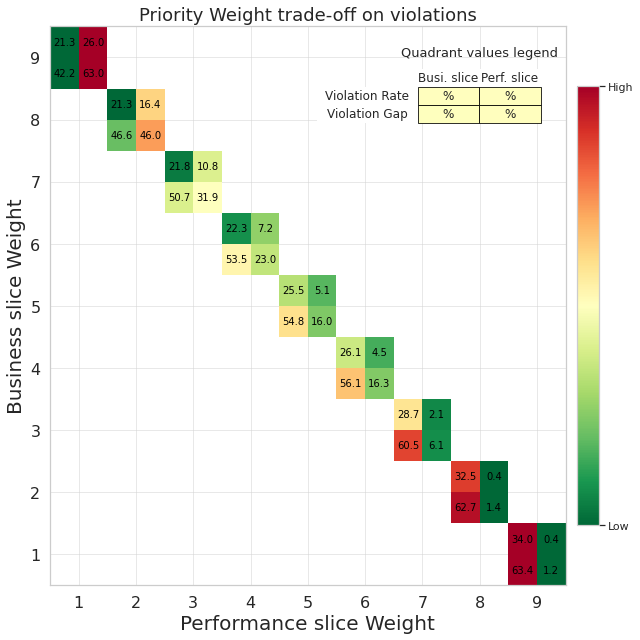

In [2]:

from matplotlib.patches import Rectangle
from matplotlib import colors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


df = pd.read_excel('weight_tradeoff.ods', engine='odf')


mat_rp = df.pivot(index='Wb', columns='Wp', values='Rate_perf')
mat_rb = df.pivot(index='Wb', columns='Wp', values='Rate_busi')
mat_gp = df.pivot(index='Wb', columns='Wp', values='gap_perf')
mat_gb = df.pivot(index='Wb', columns='Wp', values='gap_busi')

# build color‐map and normalisation on given values
cmap = plt.cm.get_cmap('RdYlGn_r')
norm_rp = colors.Normalize(mat_rp.min().min(), mat_rp.max().max())
norm_rb = colors.Normalize(mat_rb.min().min(), mat_rb.max().max())
norm_gp = colors.Normalize(mat_gp.min().min(), mat_gp.max().max())
norm_gb = colors.Normalize(mat_gb.min().min(), mat_gb.max().max())

# sorted weight axes
wp_vals = sorted(df['Wp'].unique())
wb_vals = sorted(df['Wb'].unique())


fig, ax = plt.subplots(figsize=(9,9))

for _, row in df.iterrows():
    wp, wb = row['Wp'], row['Wb']
    i = wp_vals.index(wp)
    j = wb_vals.index(wb)

    # extract data
    v_rp, v_rb = row['Rate_perf'], row['Rate_busi']
    v_gp, v_gb = row['gap_perf'],  row['gap_busi']

    # Top-Left = Rate_busi
    ax.add_patch(Rectangle((i, j+0.5), .5, .5,
                           facecolor=cmap(norm_rb(v_rb)), edgecolor='none'))
    ax.text(i+0.25, j+0.75, f'{v_rb:.1f}',
            ha='center', va='center', color='black', fontsize=10)

    # Top-Right = Rate_perf
    ax.add_patch(Rectangle((i+.5, j+0.5), .5, .5,
                           facecolor=cmap(norm_rp(v_rp)), edgecolor='none'))
    ax.text(i+0.75, j+0.75, f'{v_rp:.1f}',
            ha='center', va='center', color='black', fontsize=10)

    # Bottom-Left = gap_busi
    ax.add_patch(Rectangle((i, j), .5, .5,
                           facecolor=cmap(norm_gb(v_gb)), edgecolor='none'))
    ax.text(i+0.25, j+0.25, f'{v_gb:.1f}',
            ha='center', va='center', color='black', fontsize=10)

    # Bottom-Right = gap_perf
    ax.add_patch(Rectangle((i+.5, j), .5, .5,
                           facecolor=cmap(norm_gp(v_gp)), edgecolor='none'))
    ax.text(i+0.75, j+0.25, f'{v_gp:.1f}',
            ha='center', va='center', color='black', fontsize=10)

# ── set the axes ────────────────────────────────────────────────────────
ax.set_xlim(0, len(wp_vals))
ax.set_ylim(0, len(wb_vals))

ax.set_xticks(np.arange(len(wp_vals)) + 0.5)
ax.set_xticklabels(wp_vals)
ax.tick_params(axis='x', labelsize=16)
ax.set_xlabel('Performance slice Weight', fontsize=20)

ax.set_yticks(np.arange(len(wb_vals)) + 0.5)
ax.set_yticklabels(wb_vals)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('Business slice Weight', fontsize=20)

ax.set_title('Priority Weight trade-off on violations', fontsize=18)

# set the grey grid intersections
ax.set_axisbelow(True)
ax.grid(which='both', color='lightgrey', linestyle='-', linewidth=0.5)

# ── Add the "Quadrant legend” 
legend_ax = fig.add_axes([0.65, 0.75, 0.19, 0.19])  # [left, bottom, width, height]
legend_ax.axis('off')

# sample mid-points to pull match-colormap colors
mid_rb = 0.5*(norm_rb.vmin + norm_rb.vmax)
mid_rp = 0.5*(norm_rp.vmin + norm_rp.vmax)
mid_gb = 0.5*(norm_gb.vmin + norm_gb.vmax)
mid_gp = 0.5*(norm_gp.vmin + norm_gp.vmax)

c_tl = cmap(norm_rb(mid_rb))
c_tr = cmap(norm_rp(mid_rp))
c_bl = cmap(norm_gb(mid_gb))
c_br = cmap(norm_gp(mid_gp))

tbl = legend_ax.table(
    cellText=[['%', '%'],
              ['%', '%']],
    cellColours=[[c_tl, c_tr],
                 [c_bl, c_br]],      
    rowLabels=['Violation Rate', 'Violation Gap'],
    colLabels=['Busi. slice', 'Perf. slice'],
    cellLoc='center',
    rowLoc='center',
    colLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1, 1.5)
legend_ax.text(0.5, 0.8,     
    'Quadrant values legend',
    transform=legend_ax.transAxes, ha='center', va='bottom', fontsize=13)

# draw borders around the four data cells
for (r, c), cell in tbl.get_celld().items():
    if r > 0 and c >= 0:
        cell.set_edgecolor('black')
        cell.set_linewidth(0.8)
    else:
        cell.set_edgecolor('none')
        cell.set_linewidth(0)


# create a color legend for a 0→1 ramp
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=1))
sm.set_array([])  

# add the colorbar to the main axes
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.04, pad=0.02) 


cbar.set_ticks([0,1])
cbar.set_ticklabels(['Low','High'])


plt.tight_layout()
plt.show()
